# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

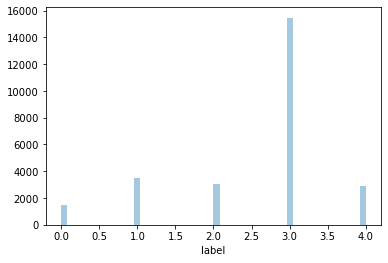

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "deit_base_patch16_384"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 24
    gradient_accumulation_steps = 1
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = False
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = 10  # len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 1678
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

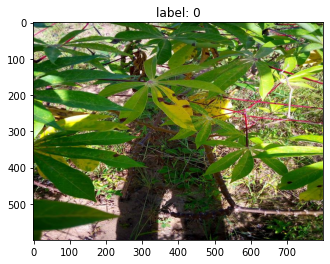

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

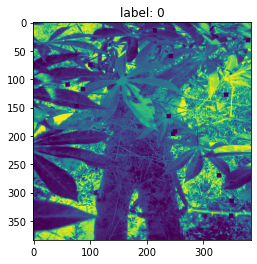

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, y_b, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if model_name == "resnext50_32x4d":
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


tensor([[-0.0208, -0.4203, -0.3296, -0.3727, -0.2957],
        [ 0.4300,  0.5697, -0.5852, -0.2904, -0.6494],
        [-0.2021,  0.3233, -0.2990, -0.1001, -0.3108],
        [ 0.1591, -0.3995, -0.9225,  0.0098, -0.7758]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))
        # elif mix_decision >= 0.5 and mix_decision < 0.75:
        #     images, labels = mixup(images, labels, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.5:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch: [1][0/877] Elapsed 0m 1s (remain 29m 2s) Loss: 0.5448(0.5448) Grad: 2.9426 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 41s (remain 5m 22s) Loss: 0.1324(0.2243) Grad: 1.5020 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 21s (remain 4m 35s) Loss: 0.1770(0.1961) Grad: 0.9164 LR: 0.000100  
Epoch: [1][300/877] Elapsed 2m 1s (remain 3m 53s) Loss: 0.1189(0.1775) Grad: 1.4230 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 41s (remain 3m 11s) Loss: 0.0928(0.1652) Grad: 0.6622 LR: 0.000100  
Epoch: [1][500/877] Elapsed 3m 21s (remain 2m 31s) Loss: 0.1411(0.1598) Grad: 0.8148 LR: 0.000100  
Epoch: [1][600/877] Elapsed 4m 1s (remain 1m 50s) Loss: 0.0727(0.1547) Grad: 0.7946 LR: 0.000100  
Epoch: [1][700/877] Elapsed 4m 41s (remain 1m 10s) Loss: 0.0503(0.1512) Grad: 0.9545 LR: 0.000100  
Epoch: [1][800/877] Elapsed 5m 20s (remain 0m 30s) Loss: 0.0988(0.1483) Grad: 0.7853 LR: 0.000100  
Epoch: [1][876/877] Elapsed 5m 51s (remain 0m 0s) Loss: 0.0994(0.1482) Grad: 1.2467 LR: 0.000100  
EVAL: 

Epoch 1 - avg_train_loss: 0.1482  avg_val_loss: 0.1197  time: 382s
Epoch 1 - Accuracy: 0.8614274867122248
Epoch 1 - Save Best Score: 0.8614 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1104(0.1197) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 18m 42s) Loss: 0.0690(0.0690) Grad: 0.4282 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 41s (remain 5m 16s) Loss: 0.1043(0.0854) Grad: 1.3934 LR: 0.000098  
Epoch: [2][200/877] Elapsed 1m 21s (remain 4m 32s) Loss: 0.0513(0.0932) Grad: 0.4943 LR: 0.000098  
Epoch: [2][300/877] Elapsed 2m 0s (remain 3m 51s) Loss: 0.0028(0.0913) Grad: 0.1455 LR: 0.000098  
Epoch: [2][400/877] Elapsed 2m 40s (remain 3m 10s) Loss: 0.0848(0.0944) Grad: 0.8419 LR: 0.000098  
Epoch: [2][500/877] Elapsed 3m 20s (remain 2m 30s) Loss: 0.1251(0.0948) Grad: 0.7950 LR: 0.000098  
Epoch: [2][600/877] Elapsed 4m 0s (remain 1m 50s) Loss: 0.1235(0.0959) Grad: 1.1782 LR: 0.000098  
Epoch: [2][700/877] Elapsed 4m 40s (remain 1m 10s) Loss: 0.1380(0.0954) Grad: 0.9007 LR: 0.000098  
Epoch: [2][800/877] Elapsed 5m 20s (remain 0m 30s) Loss: 0.0699(0.0958) Grad: 0.5199 LR: 0.000098  
Epoch: [2][876/877] Elapsed 5m 51s (

Epoch 2 - avg_train_loss: 0.0970  avg_val_loss: 0.1217  time: 382s
Epoch 2 - Accuracy: 0.8618071374335611
Epoch 2 - Save Best Score: 0.8618 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2037(0.1217) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 20m 47s) Loss: 0.1880(0.1880) Grad: 1.1221 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 42s (remain 5m 28s) Loss: 0.3416(0.2033) Grad: 0.5197 LR: 0.000091  
Epoch: [3][200/877] Elapsed 1m 24s (remain 4m 43s) Loss: 0.2213(0.1993) Grad: 0.4736 LR: 0.000091  
Epoch: [3][300/877] Elapsed 2m 5s (remain 4m 0s) Loss: 0.0919(0.1923) Grad: 0.5282 LR: 0.000091  
Epoch: [3][400/877] Elapsed 2m 46s (remain 3m 18s) Loss: 0.1093(0.1873) Grad: 0.8789 LR: 0.000091  
Epoch: [3][500/877] Elapsed 3m 28s (remain 2m 36s) Loss: 0.3424(0.1871) Grad: 0.5546 LR: 0.000091  
Epoch: [3][600/877] Elapsed 4m 9s (remain 1m 54s) Loss: 0.2305(0.1868) Grad: 0.7840 LR: 0.000091  
Epoch: [3][700/877] Elapsed 4m 51s (remain 1m 13s) Loss: 0.2086(0.1860) Grad: 0.4044 LR: 0.000091  
Epoch: [3][800/877] Elapsed 5m 31s (remain 0m 31s) Loss: 0.3879(0.1851) Grad: 0.6343 LR: 0.000091  
Epoch: [3][876/877] Elapsed 6m 3s (re

Epoch 3 - avg_train_loss: 0.1859  avg_val_loss: 0.1228  time: 395s
Epoch 3 - Accuracy: 0.8591495823842066


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1391(0.1228) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 21m 59s) Loss: 0.1375(0.1375) Grad: 0.7956 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 42s (remain 5m 29s) Loss: 0.1924(0.1707) Grad: 0.3331 LR: 0.000080  
Epoch: [4][200/877] Elapsed 1m 24s (remain 4m 42s) Loss: 0.1105(0.1735) Grad: 0.4497 LR: 0.000080  
Epoch: [4][300/877] Elapsed 2m 5s (remain 3m 59s) Loss: 0.2138(0.1731) Grad: 0.4293 LR: 0.000080  
Epoch: [4][400/877] Elapsed 2m 46s (remain 3m 17s) Loss: 0.1137(0.1752) Grad: 0.6098 LR: 0.000080  
Epoch: [4][500/877] Elapsed 3m 26s (remain 2m 35s) Loss: 0.1066(0.1762) Grad: 0.4410 LR: 0.000080  
Epoch: [4][600/877] Elapsed 4m 7s (remain 1m 53s) Loss: 0.1015(0.1758) Grad: 0.8259 LR: 0.000080  
Epoch: [4][700/877] Elapsed 4m 48s (remain 1m 12s) Loss: 0.1566(0.1751) Grad: 0.6276 LR: 0.000080  
Epoch: [4][800/877] Elapsed 5m 29s (remain 0m 31s) Loss: 0.0800(0.1746) Grad: 0.8022 LR: 0.000080  
Epoch: [4][876/877] Elapsed 6m 0s (r

Epoch 4 - avg_train_loss: 0.1746  avg_val_loss: 0.1125  time: 392s
Epoch 4 - Accuracy: 0.8737661351556568
Epoch 4 - Save Best Score: 0.8738 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2182(0.1125) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 22m 8s) Loss: 0.1095(0.1095) Grad: 0.3433 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 42s (remain 5m 23s) Loss: 0.1744(0.1620) Grad: 0.9995 LR: 0.000066  
Epoch: [5][200/877] Elapsed 1m 22s (remain 4m 38s) Loss: 0.1391(0.1629) Grad: 0.7710 LR: 0.000066  
Epoch: [5][300/877] Elapsed 2m 3s (remain 3m 56s) Loss: 0.1668(0.1630) Grad: 0.7601 LR: 0.000066  
Epoch: [5][400/877] Elapsed 2m 44s (remain 3m 14s) Loss: 0.1751(0.1667) Grad: 0.5198 LR: 0.000066  
Epoch: [5][500/877] Elapsed 3m 24s (remain 2m 33s) Loss: 0.2457(0.1674) Grad: 0.3524 LR: 0.000066  
Epoch: [5][600/877] Elapsed 4m 5s (remain 1m 52s) Loss: 0.1732(0.1661) Grad: 0.5603 LR: 0.000066  
Epoch: [5][700/877] Elapsed 4m 46s (remain 1m 11s) Loss: 0.1341(0.1676) Grad: 0.8983 LR: 0.000066  
Epoch: [5][800/877] Elapsed 5m 27s (remain 0m 31s) Loss: 0.2586(0.1679) Grad: 0.4804 LR: 0.000066  
Epoch: [5][876/877] Elapsed 5m 58s (r

Epoch 5 - avg_train_loss: 0.1679  avg_val_loss: 0.1046  time: 389s
Epoch 5 - Accuracy: 0.8843963553530751
Epoch 5 - Save Best Score: 0.8844 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2090(0.1046) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 22m 19s) Loss: 0.1058(0.1058) Grad: 0.3310 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 42s (remain 5m 23s) Loss: 0.2921(0.1643) Grad: 0.5047 LR: 0.000051  
Epoch: [6][200/877] Elapsed 1m 22s (remain 4m 38s) Loss: 0.2975(0.1708) Grad: 0.8286 LR: 0.000051  
Epoch: [6][300/877] Elapsed 2m 3s (remain 3m 56s) Loss: 0.0986(0.1683) Grad: 0.9283 LR: 0.000051  
Epoch: [6][400/877] Elapsed 2m 44s (remain 3m 15s) Loss: 0.2189(0.1664) Grad: 0.4704 LR: 0.000051  
Epoch: [6][500/877] Elapsed 3m 25s (remain 2m 33s) Loss: 0.1929(0.1661) Grad: 0.2951 LR: 0.000051  
Epoch: [6][600/877] Elapsed 4m 5s (remain 1m 52s) Loss: 0.0767(0.1669) Grad: 0.4413 LR: 0.000051  
Epoch: [6][700/877] Elapsed 4m 46s (remain 1m 11s) Loss: 0.1976(0.1667) Grad: 0.3155 LR: 0.000051  
Epoch: [6][800/877] Elapsed 5m 27s (remain 0m 31s) Loss: 0.0831(0.1663) Grad: 0.5318 LR: 0.000051  
Epoch: [6][876/877] Elapsed 5m 58s (

Epoch 6 - avg_train_loss: 0.1656  avg_val_loss: 0.1101  time: 388s
Epoch 6 - Accuracy: 0.8741457858769932


EVAL: [219/220] Elapsed 0m 29s (remain 0m 0s) Loss: 0.1409(0.1101) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 21m 47s) Loss: 0.0963(0.0963) Grad: 0.2834 LR: 0.000035  
Epoch: [7][100/877] Elapsed 0m 41s (remain 5m 20s) Loss: 0.1358(0.1290) Grad: 0.6794 LR: 0.000035  
Epoch: [7][200/877] Elapsed 1m 22s (remain 4m 36s) Loss: 0.1947(0.1268) Grad: 1.0001 LR: 0.000035  
Epoch: [7][300/877] Elapsed 2m 2s (remain 3m 54s) Loss: 0.1128(0.1261) Grad: 0.7738 LR: 0.000035  
Epoch: [7][400/877] Elapsed 2m 42s (remain 3m 13s) Loss: 0.0972(0.1280) Grad: 0.9242 LR: 0.000035  
Epoch: [7][500/877] Elapsed 3m 23s (remain 2m 32s) Loss: 0.1347(0.1287) Grad: 0.7990 LR: 0.000035  
Epoch: [7][600/877] Elapsed 4m 3s (remain 1m 51s) Loss: 0.0996(0.1286) Grad: 0.6103 LR: 0.000035  
Epoch: [7][700/877] Elapsed 4m 43s (remain 1m 11s) Loss: 0.2354(0.1302) Grad: 0.5532 LR: 0.000035  
Epoch: [7][800/877] Elapsed 5m 24s (remain 0m 30s) Loss: 0.0422(0.1292) Grad: 0.7256 LR: 0.000035  
Epoch: [7][876/877] Elapsed 5m 54s (

Epoch 7 - avg_train_loss: 0.1288  avg_val_loss: 0.1060  time: 386s
Epoch 7 - Accuracy: 0.8815489749430524


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1883(0.1060) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 21m 13s) Loss: 0.1623(0.1623) Grad: 1.0218 LR: 0.000021  
Epoch: [8][100/877] Elapsed 0m 42s (remain 5m 22s) Loss: 0.0558(0.1164) Grad: 0.8218 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 22s (remain 4m 37s) Loss: 0.1731(0.1178) Grad: 0.4657 LR: 0.000021  
Epoch: [8][300/877] Elapsed 2m 2s (remain 3m 54s) Loss: 0.0517(0.1151) Grad: 0.7120 LR: 0.000021  
Epoch: [8][400/877] Elapsed 2m 43s (remain 3m 13s) Loss: 0.0610(0.1175) Grad: 0.4332 LR: 0.000021  
Epoch: [8][500/877] Elapsed 3m 23s (remain 2m 32s) Loss: 0.1103(0.1175) Grad: 0.8259 LR: 0.000021  
Epoch: [8][600/877] Elapsed 4m 3s (remain 1m 51s) Loss: 0.0846(0.1183) Grad: 0.6582 LR: 0.000021  
Epoch: [8][700/877] Elapsed 4m 44s (remain 1m 11s) Loss: 0.0259(0.1195) Grad: 0.4265 LR: 0.000021  
Epoch: [8][800/877] Elapsed 5m 24s (remain 0m 30s) Loss: 0.1151(0.1191) Grad: 0.9398 LR: 0.000021  
Epoch: [8][876/877] Elapsed 5m 55s (

Epoch 8 - avg_train_loss: 0.1208  avg_val_loss: 0.0979  time: 386s
Epoch 8 - Accuracy: 0.886294608959757
Epoch 8 - Save Best Score: 0.8863 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1462(0.0979) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 20m 56s) Loss: 0.0545(0.0545) Grad: 0.6910 LR: 0.000010  
Epoch: [9][100/877] Elapsed 0m 41s (remain 5m 20s) Loss: 0.0681(0.1108) Grad: 0.9251 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 21s (remain 4m 35s) Loss: 0.1990(0.1101) Grad: 0.8448 LR: 0.000010  
Epoch: [9][300/877] Elapsed 2m 2s (remain 3m 53s) Loss: 0.0777(0.1129) Grad: 0.7311 LR: 0.000010  
Epoch: [9][400/877] Elapsed 2m 42s (remain 3m 12s) Loss: 0.2087(0.1137) Grad: 0.4704 LR: 0.000010  
Epoch: [9][500/877] Elapsed 3m 22s (remain 2m 32s) Loss: 0.0736(0.1151) Grad: 1.0971 LR: 0.000010  
Epoch: [9][600/877] Elapsed 4m 3s (remain 1m 51s) Loss: 0.0638(0.1129) Grad: 0.5072 LR: 0.000010  
Epoch: [9][700/877] Elapsed 4m 43s (remain 1m 11s) Loss: 0.2969(0.1139) Grad: 0.5417 LR: 0.000010  
Epoch: [9][800/877] Elapsed 5m 24s (remain 0m 30s) Loss: 0.2159(0.1153) Grad: 0.4151 LR: 0.000010  
Epoch: [9][876/877] Elapsed 5m 55s (

Epoch 9 - avg_train_loss: 0.1155  avg_val_loss: 0.1003  time: 387s
Epoch 9 - Accuracy: 0.8885725132877752
Epoch 9 - Save Best Score: 0.8886 Model


EVAL: [219/220] Elapsed 0m 31s (remain 0m 0s) Loss: 0.1124(0.1003) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 19m 57s) Loss: 0.0122(0.0122) Grad: 0.3495 LR: 0.000003  
Epoch: [10][100/877] Elapsed 0m 41s (remain 5m 19s) Loss: 0.0168(0.0471) Grad: 0.4807 LR: 0.000003  
Epoch: [10][200/877] Elapsed 1m 21s (remain 4m 34s) Loss: 0.0203(0.0511) Grad: 0.5219 LR: 0.000003  
Epoch: [10][300/877] Elapsed 2m 1s (remain 3m 53s) Loss: 0.1019(0.0511) Grad: 0.2962 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 41s (remain 3m 12s) Loss: 0.0383(0.0494) Grad: 0.6300 LR: 0.000003  
Epoch: [10][500/877] Elapsed 3m 22s (remain 2m 31s) Loss: 0.0091(0.0485) Grad: 0.3132 LR: 0.000003  
Epoch: [10][600/877] Elapsed 4m 2s (remain 1m 51s) Loss: 0.0579(0.0487) Grad: 1.0901 LR: 0.000003  
Epoch: [10][700/877] Elapsed 4m 42s (remain 1m 10s) Loss: 0.0874(0.0492) Grad: 0.6463 LR: 0.000003  
Epoch: [10][800/877] Elapsed 5m 22s (remain 0m 30s) Loss: 0.0049(0.0496) Grad: 0.1715 LR: 0.000003  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0490  avg_val_loss: 0.0996  time: 383s
Epoch 10 - Accuracy: 0.8904707668944571
Epoch 10 - Save Best Score: 0.8905 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1149(0.0996) 


Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.89047
========== fold: 1 training ==========
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch: [1][0/877] Elapsed 0m 1s (remain 18m 40s) Loss: 0.4794(0.4794) Grad: 3.1742 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 42s (remain 5m 22s) Loss: 0.1334(0.2206) Grad: 0.9466 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 22s (remain 4m 38s) Loss: 0.1648(0.1919) Grad: 0.9481 LR: 0.000100  
Epoch: [1][300/877] Elapsed 2m 3s (remain 3m 56s) Loss: 0.1391(0.1750) Grad: 0.9560 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 44s (remain 3m 15s) Loss: 0.1099(0.1657) Grad: 0.9118 LR: 0.000100  
Epoch: [1][500/877] Elapsed 3m 25s (remain 2m 33s) Loss: 0.1498(0.1597) Grad: 0.7914 LR: 0.000100  
Epoch: [1][600/877] Elapsed 4m 5s (remain 1m 52s) Loss: 0.1300(0.1562) Grad: 0.7646 LR: 0.000100  
Epoch: [1][700/877] Elapsed 4m 46s (remain 1m 11s) Loss: 0.1107(0.1529) Grad: 0.9794 LR: 0.000100  
Epoch: [1][800/877] Elapsed 5m 27s (remain 0m 31s) Loss: 0.2238(0.1488) Grad: 0.8706 LR: 0.000100  
Epoch: [1][876/877] Elapsed 5m 58s (remain 0m 0s) Loss: 0.1298(0.1469) Grad: 0.9747 LR: 0.000100  
EVAL:

Epoch 1 - avg_train_loss: 0.1469  avg_val_loss: 0.1210  time: 389s
Epoch 1 - Accuracy: 0.8612376613515565
Epoch 1 - Save Best Score: 0.8612 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2447(0.1210) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 20m 50s) Loss: 0.1353(0.1353) Grad: 0.7989 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 42s (remain 5m 24s) Loss: 0.1030(0.0811) Grad: 0.7356 LR: 0.000098  
Epoch: [2][200/877] Elapsed 1m 22s (remain 4m 38s) Loss: 0.0826(0.0891) Grad: 0.8827 LR: 0.000098  
Epoch: [2][300/877] Elapsed 2m 3s (remain 3m 56s) Loss: 0.0928(0.0907) Grad: 0.7134 LR: 0.000098  
Epoch: [2][400/877] Elapsed 2m 44s (remain 3m 15s) Loss: 0.1174(0.0942) Grad: 1.2368 LR: 0.000098  
Epoch: [2][500/877] Elapsed 3m 25s (remain 2m 34s) Loss: 0.0434(0.0967) Grad: 0.5121 LR: 0.000098  
Epoch: [2][600/877] Elapsed 4m 5s (remain 1m 52s) Loss: 0.0458(0.0960) Grad: 0.4452 LR: 0.000098  
Epoch: [2][700/877] Elapsed 4m 46s (remain 1m 11s) Loss: 0.0952(0.0959) Grad: 1.4660 LR: 0.000098  
Epoch: [2][800/877] Elapsed 5m 27s (remain 0m 31s) Loss: 0.1165(0.0962) Grad: 1.0603 LR: 0.000098  
Epoch: [2][876/877] Elapsed 5m 58s (

Epoch 2 - avg_train_loss: 0.0962  avg_val_loss: 0.1274  time: 389s
Epoch 2 - Accuracy: 0.8585801063022019


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2341(0.1274) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 22m 32s) Loss: 0.3614(0.3614) Grad: 1.3272 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 43s (remain 5m 32s) Loss: 0.0676(0.2024) Grad: 0.3670 LR: 0.000091  
Epoch: [3][200/877] Elapsed 1m 24s (remain 4m 45s) Loss: 0.1038(0.1929) Grad: 0.8385 LR: 0.000091  
Epoch: [3][300/877] Elapsed 2m 6s (remain 4m 1s) Loss: 0.1719(0.1936) Grad: 0.4752 LR: 0.000091  
Epoch: [3][400/877] Elapsed 2m 48s (remain 3m 19s) Loss: 0.1161(0.1931) Grad: 0.8056 LR: 0.000091  
Epoch: [3][500/877] Elapsed 3m 29s (remain 2m 37s) Loss: 0.2824(0.1921) Grad: 0.7219 LR: 0.000091  
Epoch: [3][600/877] Elapsed 4m 11s (remain 1m 55s) Loss: 0.2366(0.1910) Grad: 0.3815 LR: 0.000091  
Epoch: [3][700/877] Elapsed 4m 52s (remain 1m 13s) Loss: 0.1910(0.1887) Grad: 0.8047 LR: 0.000091  
Epoch: [3][800/877] Elapsed 5m 34s (remain 0m 31s) Loss: 0.2358(0.1868) Grad: 0.5787 LR: 0.000091  
Epoch: [3][876/877] Elapsed 6m 6s (r

Epoch 3 - avg_train_loss: 0.1871  avg_val_loss: 0.1155  time: 397s
Epoch 3 - Accuracy: 0.871867881548975
Epoch 3 - Save Best Score: 0.8719 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2305(0.1155) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 21m 59s) Loss: 0.0867(0.0867) Grad: 0.8565 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 43s (remain 5m 30s) Loss: 0.2591(0.1782) Grad: 0.6747 LR: 0.000080  
Epoch: [4][200/877] Elapsed 1m 24s (remain 4m 45s) Loss: 0.2147(0.1768) Grad: 0.7629 LR: 0.000080  
Epoch: [4][300/877] Elapsed 2m 6s (remain 4m 2s) Loss: 0.0925(0.1763) Grad: 0.7675 LR: 0.000080  
Epoch: [4][400/877] Elapsed 2m 48s (remain 3m 19s) Loss: 0.2096(0.1779) Grad: 0.3944 LR: 0.000080  
Epoch: [4][500/877] Elapsed 3m 30s (remain 2m 37s) Loss: 0.1529(0.1787) Grad: 0.4927 LR: 0.000080  
Epoch: [4][600/877] Elapsed 4m 11s (remain 1m 55s) Loss: 0.0973(0.1779) Grad: 0.6210 LR: 0.000080  
Epoch: [4][700/877] Elapsed 4m 53s (remain 1m 13s) Loss: 0.1964(0.1790) Grad: 0.4016 LR: 0.000080  
Epoch: [4][800/877] Elapsed 5m 34s (remain 0m 31s) Loss: 0.2682(0.1775) Grad: 0.5537 LR: 0.000080  
Epoch: [4][876/877] Elapsed 6m 6s (r

Epoch 4 - avg_train_loss: 0.1766  avg_val_loss: 0.1136  time: 397s
Epoch 4 - Accuracy: 0.8737661351556568
Epoch 4 - Save Best Score: 0.8738 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2105(0.1136) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 20m 54s) Loss: 0.1455(0.1455) Grad: 0.7858 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 43s (remain 5m 32s) Loss: 0.3772(0.1631) Grad: 0.8272 LR: 0.000066  
Epoch: [5][200/877] Elapsed 1m 25s (remain 4m 46s) Loss: 0.0966(0.1656) Grad: 0.4906 LR: 0.000066  
Epoch: [5][300/877] Elapsed 2m 6s (remain 4m 2s) Loss: 0.0744(0.1669) Grad: 0.5402 LR: 0.000066  
Epoch: [5][400/877] Elapsed 2m 48s (remain 3m 19s) Loss: 0.0989(0.1695) Grad: 0.7262 LR: 0.000066  
Epoch: [5][500/877] Elapsed 3m 29s (remain 2m 37s) Loss: 0.2584(0.1714) Grad: 0.3060 LR: 0.000066  
Epoch: [5][600/877] Elapsed 4m 11s (remain 1m 55s) Loss: 0.1173(0.1713) Grad: 0.7598 LR: 0.000066  
Epoch: [5][700/877] Elapsed 4m 52s (remain 1m 13s) Loss: 0.2212(0.1722) Grad: 0.8277 LR: 0.000066  
Epoch: [5][800/877] Elapsed 5m 34s (remain 0m 31s) Loss: 0.1526(0.1744) Grad: 0.6919 LR: 0.000066  
Epoch: [5][876/877] Elapsed 6m 5s (r

Epoch 5 - avg_train_loss: 0.1741  avg_val_loss: 0.1122  time: 396s
Epoch 5 - Accuracy: 0.8749050873196659
Epoch 5 - Save Best Score: 0.8749 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2500(0.1122) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 22m 20s) Loss: 0.2182(0.2182) Grad: 0.6045 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 42s (remain 5m 28s) Loss: 0.2360(0.1652) Grad: 0.4373 LR: 0.000051  
Epoch: [6][200/877] Elapsed 1m 24s (remain 4m 43s) Loss: 0.1313(0.1623) Grad: 0.6711 LR: 0.000051  
Epoch: [6][300/877] Elapsed 2m 5s (remain 4m 0s) Loss: 0.1431(0.1645) Grad: 0.3419 LR: 0.000051  
Epoch: [6][400/877] Elapsed 2m 47s (remain 3m 18s) Loss: 0.1475(0.1667) Grad: 1.0769 LR: 0.000051  
Epoch: [6][500/877] Elapsed 3m 28s (remain 2m 36s) Loss: 0.0258(0.1654) Grad: 0.5379 LR: 0.000051  
Epoch: [6][600/877] Elapsed 4m 10s (remain 1m 54s) Loss: 0.1780(0.1649) Grad: 0.6491 LR: 0.000051  
Epoch: [6][700/877] Elapsed 4m 51s (remain 1m 13s) Loss: 0.2261(0.1673) Grad: 0.4907 LR: 0.000051  
Epoch: [6][800/877] Elapsed 5m 33s (remain 0m 31s) Loss: 0.2520(0.1680) Grad: 0.2992 LR: 0.000051  
Epoch: [6][876/877] Elapsed 6m 4s (r

Epoch 6 - avg_train_loss: 0.1675  avg_val_loss: 0.1064  time: 395s
Epoch 6 - Accuracy: 0.8798405466970387
Epoch 6 - Save Best Score: 0.8798 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2120(0.1064) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 21m 30s) Loss: 0.2575(0.2575) Grad: 0.6558 LR: 0.000035  
Epoch: [7][100/877] Elapsed 0m 42s (remain 5m 28s) Loss: 0.1751(0.1276) Grad: 0.5962 LR: 0.000035  
Epoch: [7][200/877] Elapsed 1m 24s (remain 4m 42s) Loss: 0.1097(0.1218) Grad: 0.7864 LR: 0.000035  
Epoch: [7][300/877] Elapsed 2m 4s (remain 3m 59s) Loss: 0.0387(0.1248) Grad: 0.4769 LR: 0.000035  
Epoch: [7][400/877] Elapsed 2m 46s (remain 3m 17s) Loss: 0.1226(0.1273) Grad: 0.4323 LR: 0.000035  
Epoch: [7][500/877] Elapsed 3m 27s (remain 2m 35s) Loss: 0.1214(0.1284) Grad: 1.1338 LR: 0.000035  
Epoch: [7][600/877] Elapsed 4m 8s (remain 1m 54s) Loss: 0.2016(0.1293) Grad: 0.5124 LR: 0.000035  
Epoch: [7][700/877] Elapsed 4m 49s (remain 1m 12s) Loss: 0.1255(0.1297) Grad: 0.4427 LR: 0.000035  
Epoch: [7][800/877] Elapsed 5m 31s (remain 0m 31s) Loss: 0.0268(0.1305) Grad: 0.4647 LR: 0.000035  
Epoch: [7][876/877] Elapsed 6m 2s (r

Epoch 7 - avg_train_loss: 0.1296  avg_val_loss: 0.1043  time: 392s
Epoch 7 - Accuracy: 0.8830675778283978
Epoch 7 - Save Best Score: 0.8831 Model


EVAL: [219/220] Elapsed 0m 29s (remain 0m 0s) Loss: 0.2352(0.1043) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 22m 10s) Loss: 0.1208(0.1208) Grad: 0.8340 LR: 0.000021  
Epoch: [8][100/877] Elapsed 0m 42s (remain 5m 27s) Loss: 0.0599(0.1282) Grad: 0.5726 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 23s (remain 4m 42s) Loss: 0.1572(0.1230) Grad: 0.7846 LR: 0.000021  
Epoch: [8][300/877] Elapsed 2m 5s (remain 3m 59s) Loss: 0.1250(0.1217) Grad: 0.9553 LR: 0.000021  
Epoch: [8][400/877] Elapsed 2m 46s (remain 3m 17s) Loss: 0.2963(0.1213) Grad: 0.5990 LR: 0.000021  
Epoch: [8][500/877] Elapsed 3m 27s (remain 2m 35s) Loss: 0.0231(0.1199) Grad: 0.5583 LR: 0.000021  
Epoch: [8][600/877] Elapsed 4m 8s (remain 1m 54s) Loss: 0.2239(0.1197) Grad: 0.6464 LR: 0.000021  
Epoch: [8][700/877] Elapsed 4m 49s (remain 1m 12s) Loss: 0.1248(0.1201) Grad: 0.8485 LR: 0.000021  
Epoch: [8][800/877] Elapsed 5m 30s (remain 0m 31s) Loss: 0.0684(0.1203) Grad: 0.6072 LR: 0.000021  
Epoch: [8][876/877] Elapsed 6m 1s (r

Epoch 8 - avg_train_loss: 0.1210  avg_val_loss: 0.1048  time: 392s
Epoch 8 - Accuracy: 0.8824981017463933


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2152(0.1048) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 22m 39s) Loss: 0.2471(0.2471) Grad: 0.5340 LR: 0.000010  
Epoch: [9][100/877] Elapsed 0m 42s (remain 5m 29s) Loss: 0.0880(0.1173) Grad: 0.4350 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 23s (remain 4m 42s) Loss: 0.1127(0.1120) Grad: 0.8575 LR: 0.000010  
Epoch: [9][300/877] Elapsed 2m 4s (remain 3m 59s) Loss: 0.0790(0.1110) Grad: 0.8326 LR: 0.000010  
Epoch: [9][400/877] Elapsed 2m 46s (remain 3m 17s) Loss: 0.2120(0.1113) Grad: 0.7374 LR: 0.000010  
Epoch: [9][500/877] Elapsed 3m 27s (remain 2m 35s) Loss: 0.1169(0.1110) Grad: 0.8112 LR: 0.000010  
Epoch: [9][600/877] Elapsed 4m 8s (remain 1m 54s) Loss: 0.0102(0.1120) Grad: 0.3345 LR: 0.000010  
Epoch: [9][700/877] Elapsed 4m 50s (remain 1m 12s) Loss: 0.1080(0.1126) Grad: 0.3165 LR: 0.000010  
Epoch: [9][800/877] Elapsed 5m 31s (remain 0m 31s) Loss: 0.1569(0.1128) Grad: 0.4115 LR: 0.000010  
Epoch: [9][876/877] Elapsed 6m 2s (r

Epoch 9 - avg_train_loss: 0.1137  avg_val_loss: 0.1020  time: 393s
Epoch 9 - Accuracy: 0.8859149582384207
Epoch 9 - Save Best Score: 0.8859 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.2373(0.1020) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 20m 35s) Loss: 0.0171(0.0171) Grad: 0.4988 LR: 0.000003  
Epoch: [10][100/877] Elapsed 0m 42s (remain 5m 23s) Loss: 0.0740(0.0472) Grad: 0.6961 LR: 0.000003  
Epoch: [10][200/877] Elapsed 1m 22s (remain 4m 38s) Loss: 0.0401(0.0485) Grad: 0.5742 LR: 0.000003  
Epoch: [10][300/877] Elapsed 2m 3s (remain 3m 56s) Loss: 0.0106(0.0497) Grad: 0.3043 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 44s (remain 3m 15s) Loss: 0.0541(0.0493) Grad: 0.4430 LR: 0.000003  
Epoch: [10][500/877] Elapsed 3m 25s (remain 2m 33s) Loss: 0.0646(0.0493) Grad: 1.1024 LR: 0.000003  
Epoch: [10][600/877] Elapsed 4m 6s (remain 1m 52s) Loss: 0.0323(0.0480) Grad: 0.7606 LR: 0.000003  
Epoch: [10][700/877] Elapsed 4m 46s (remain 1m 11s) Loss: 0.0031(0.0481) Grad: 0.1577 LR: 0.000003  
Epoch: [10][800/877] Elapsed 5m 27s (remain 0m 31s) Loss: 0.0091(0.0484) Grad: 0.2571 LR: 0.000003  
Epoch: [10][876/877] Elapse

Epoch 10 - avg_train_loss: 0.0479  avg_val_loss: 0.1014  time: 389s
Epoch 10 - Accuracy: 0.8908504176157934
Epoch 10 - Save Best Score: 0.8909 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.1984(0.1014) 


Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.89085
========== fold: 2 training ==========
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch: [1][0/877] Elapsed 0m 1s (remain 18m 50s) Loss: 0.4609(0.4609) Grad: 3.1929 LR: 0.000100  
Epoch: [1][100/877] Elapsed 0m 42s (remain 5m 28s) Loss: 0.1927(0.2381) Grad: 1.1231 LR: 0.000100  
Epoch: [1][200/877] Elapsed 1m 24s (remain 4m 43s) Loss: 0.0728(0.2022) Grad: 0.7844 LR: 0.000100  
Epoch: [1][300/877] Elapsed 2m 5s (remain 4m 1s) Loss: 0.1853(0.1799) Grad: 1.0865 LR: 0.000100  
Epoch: [1][400/877] Elapsed 2m 47s (remain 3m 18s) Loss: 0.1130(0.1706) Grad: 0.6120 LR: 0.000100  
Epoch: [1][500/877] Elapsed 3m 29s (remain 2m 36s) Loss: 0.1194(0.1629) Grad: 0.9316 LR: 0.000100  
Epoch: [1][600/877] Elapsed 4m 10s (remain 1m 55s) Loss: 0.1838(0.1582) Grad: 1.4118 LR: 0.000100  
Epoch: [1][700/877] Elapsed 4m 52s (remain 1m 13s) Loss: 0.1191(0.1531) Grad: 0.7042 LR: 0.000100  
Epoch: [1][800/877] Elapsed 5m 33s (remain 0m 31s) Loss: 0.0947(0.1507) Grad: 1.0222 LR: 0.000100  
Epoch: [1][876/877] Elapsed 6m 5s (remain 0m 0s) Loss: 0.1347(0.1488) Grad: 0.9460 LR: 0.000100  
EVAL: 

Epoch 1 - avg_train_loss: 0.1488  avg_val_loss: 0.1109  time: 395s
Epoch 1 - Accuracy: 0.8764002278336814
Epoch 1 - Save Best Score: 0.8764 Model


EVAL: [219/220] Elapsed 0m 29s (remain 0m 0s) Loss: 0.0155(0.1109) 
Epoch: [2][0/877] Elapsed 0m 1s (remain 20m 17s) Loss: 0.0183(0.0183) Grad: 0.7877 LR: 0.000098  
Epoch: [2][100/877] Elapsed 0m 42s (remain 5m 29s) Loss: 0.1071(0.0895) Grad: 0.2962 LR: 0.000098  
Epoch: [2][200/877] Elapsed 1m 24s (remain 4m 43s) Loss: 0.1006(0.0934) Grad: 1.1365 LR: 0.000098  
Epoch: [2][300/877] Elapsed 2m 5s (remain 4m 0s) Loss: 0.0996(0.0942) Grad: 0.9107 LR: 0.000098  
Epoch: [2][400/877] Elapsed 2m 47s (remain 3m 18s) Loss: 0.1390(0.0958) Grad: 0.6127 LR: 0.000098  
Epoch: [2][500/877] Elapsed 3m 28s (remain 2m 36s) Loss: 0.1082(0.0980) Grad: 0.9976 LR: 0.000098  
Epoch: [2][600/877] Elapsed 4m 10s (remain 1m 54s) Loss: 0.0885(0.0980) Grad: 1.1016 LR: 0.000098  
Epoch: [2][700/877] Elapsed 4m 51s (remain 1m 13s) Loss: 0.0914(0.0964) Grad: 1.0116 LR: 0.000098  
Epoch: [2][800/877] Elapsed 5m 33s (remain 0m 31s) Loss: 0.1037(0.0982) Grad: 1.1718 LR: 0.000098  
Epoch: [2][876/877] Elapsed 6m 4s (r

Epoch 2 - avg_train_loss: 0.0992  avg_val_loss: 0.1191  time: 395s
Epoch 2 - Accuracy: 0.8640592367571672


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0142(0.1191) 
Epoch: [3][0/877] Elapsed 0m 1s (remain 21m 34s) Loss: 0.1733(0.1733) Grad: 0.8994 LR: 0.000091  
Epoch: [3][100/877] Elapsed 0m 43s (remain 5m 36s) Loss: 0.1038(0.1981) Grad: 0.6688 LR: 0.000091  
Epoch: [3][200/877] Elapsed 1m 26s (remain 4m 49s) Loss: 0.1925(0.1969) Grad: 1.0580 LR: 0.000091  
Epoch: [3][300/877] Elapsed 2m 8s (remain 4m 5s) Loss: 0.1061(0.1955) Grad: 0.4539 LR: 0.000091  
Epoch: [3][400/877] Elapsed 2m 50s (remain 3m 22s) Loss: 0.1457(0.1934) Grad: 0.5916 LR: 0.000091  
Epoch: [3][500/877] Elapsed 3m 32s (remain 2m 39s) Loss: 0.2333(0.1929) Grad: 0.4888 LR: 0.000091  
Epoch: [3][600/877] Elapsed 4m 15s (remain 1m 57s) Loss: 0.1380(0.1913) Grad: 0.9087 LR: 0.000091  
Epoch: [3][700/877] Elapsed 4m 57s (remain 1m 14s) Loss: 0.2097(0.1880) Grad: 0.4087 LR: 0.000091  
Epoch: [3][800/877] Elapsed 5m 39s (remain 0m 32s) Loss: 0.0861(0.1882) Grad: 0.7250 LR: 0.000091  
Epoch: [3][876/877] Elapsed 6m 12s (

Epoch 3 - avg_train_loss: 0.1891  avg_val_loss: 0.1132  time: 403s
Epoch 3 - Accuracy: 0.8737421682172014


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0348(0.1132) 
Epoch: [4][0/877] Elapsed 0m 1s (remain 22m 28s) Loss: 0.2150(0.2150) Grad: 0.3266 LR: 0.000080  
Epoch: [4][100/877] Elapsed 0m 43s (remain 5m 36s) Loss: 0.1826(0.1789) Grad: 0.7284 LR: 0.000080  
Epoch: [4][200/877] Elapsed 1m 26s (remain 4m 50s) Loss: 0.2163(0.1761) Grad: 0.6214 LR: 0.000080  
Epoch: [4][300/877] Elapsed 2m 8s (remain 4m 6s) Loss: 0.2589(0.1786) Grad: 0.6372 LR: 0.000080  
Epoch: [4][400/877] Elapsed 2m 50s (remain 3m 22s) Loss: 0.0999(0.1783) Grad: 0.8347 LR: 0.000080  
Epoch: [4][500/877] Elapsed 3m 32s (remain 2m 39s) Loss: 0.2067(0.1793) Grad: 0.7229 LR: 0.000080  
Epoch: [4][600/877] Elapsed 4m 15s (remain 1m 57s) Loss: 0.3185(0.1794) Grad: 0.5900 LR: 0.000080  
Epoch: [4][700/877] Elapsed 4m 57s (remain 1m 14s) Loss: 0.1838(0.1792) Grad: 0.4644 LR: 0.000080  
Epoch: [4][800/877] Elapsed 5m 39s (remain 0m 32s) Loss: 0.2806(0.1797) Grad: 0.5012 LR: 0.000080  
Epoch: [4][876/877] Elapsed 6m 11s (

Epoch 4 - avg_train_loss: 0.1794  avg_val_loss: 0.1118  time: 402s
Epoch 4 - Accuracy: 0.8724131384089615


EVAL: [219/220] Elapsed 0m 29s (remain 0m 0s) Loss: 0.0156(0.1118) 
Epoch: [5][0/877] Elapsed 0m 1s (remain 21m 53s) Loss: 0.2273(0.2273) Grad: 0.6308 LR: 0.000066  
Epoch: [5][100/877] Elapsed 0m 43s (remain 5m 37s) Loss: 0.1239(0.1724) Grad: 0.7010 LR: 0.000066  
Epoch: [5][200/877] Elapsed 1m 26s (remain 4m 49s) Loss: 0.0690(0.1739) Grad: 1.0142 LR: 0.000066  
Epoch: [5][300/877] Elapsed 2m 8s (remain 4m 5s) Loss: 0.1212(0.1664) Grad: 0.7417 LR: 0.000066  
Epoch: [5][400/877] Elapsed 2m 50s (remain 3m 22s) Loss: 0.0954(0.1694) Grad: 0.8960 LR: 0.000066  
Epoch: [5][500/877] Elapsed 3m 33s (remain 2m 40s) Loss: 0.2120(0.1693) Grad: 0.5553 LR: 0.000066  
Epoch: [5][600/877] Elapsed 4m 15s (remain 1m 57s) Loss: 0.1191(0.1693) Grad: 0.7575 LR: 0.000066  
Epoch: [5][700/877] Elapsed 4m 58s (remain 1m 14s) Loss: 0.1048(0.1688) Grad: 0.6805 LR: 0.000066  
Epoch: [5][800/877] Elapsed 5m 40s (remain 0m 32s) Loss: 0.2889(0.1702) Grad: 0.5219 LR: 0.000066  
Epoch: [5][876/877] Elapsed 6m 12s (

Epoch 5 - avg_train_loss: 0.1695  avg_val_loss: 0.1046  time: 403s
Epoch 5 - Accuracy: 0.8832352382760584
Epoch 5 - Save Best Score: 0.8832 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0098(0.1046) 
Epoch: [6][0/877] Elapsed 0m 1s (remain 22m 8s) Loss: 0.2583(0.2583) Grad: 0.5468 LR: 0.000051  
Epoch: [6][100/877] Elapsed 0m 43s (remain 5m 36s) Loss: 0.2526(0.1651) Grad: 0.5206 LR: 0.000051  
Epoch: [6][200/877] Elapsed 1m 25s (remain 4m 48s) Loss: 0.2232(0.1609) Grad: 0.4584 LR: 0.000051  
Epoch: [6][300/877] Elapsed 2m 8s (remain 4m 5s) Loss: 0.0410(0.1652) Grad: 0.6971 LR: 0.000051  
Epoch: [6][400/877] Elapsed 2m 50s (remain 3m 22s) Loss: 0.0369(0.1624) Grad: 0.4969 LR: 0.000051  
Epoch: [6][500/877] Elapsed 3m 32s (remain 2m 39s) Loss: 0.0637(0.1642) Grad: 0.5376 LR: 0.000051  
Epoch: [6][600/877] Elapsed 4m 14s (remain 1m 57s) Loss: 0.2282(0.1640) Grad: 0.3809 LR: 0.000051  
Epoch: [6][700/877] Elapsed 4m 57s (remain 1m 14s) Loss: 0.0334(0.1642) Grad: 0.6224 LR: 0.000051  
Epoch: [6][800/877] Elapsed 5m 39s (remain 0m 32s) Loss: 0.2016(0.1635) Grad: 0.8614 LR: 0.000051  
Epoch: [6][876/877] Elapsed 6m 11s (r

Epoch 6 - avg_train_loss: 0.1629  avg_val_loss: 0.1061  time: 402s
Epoch 6 - Accuracy: 0.8845642680842984
Epoch 6 - Save Best Score: 0.8846 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0121(0.1061) 
Epoch: [7][0/877] Elapsed 0m 1s (remain 20m 0s) Loss: 0.1178(0.1178) Grad: 1.4695 LR: 0.000035  
Epoch: [7][100/877] Elapsed 0m 43s (remain 5m 34s) Loss: 0.0435(0.1283) Grad: 0.5488 LR: 0.000035  
Epoch: [7][200/877] Elapsed 1m 25s (remain 4m 48s) Loss: 0.0638(0.1306) Grad: 0.4059 LR: 0.000035  
Epoch: [7][300/877] Elapsed 2m 7s (remain 4m 4s) Loss: 0.1337(0.1292) Grad: 0.5469 LR: 0.000035  
Epoch: [7][400/877] Elapsed 2m 49s (remain 3m 21s) Loss: 0.1259(0.1292) Grad: 0.6915 LR: 0.000035  
Epoch: [7][500/877] Elapsed 3m 31s (remain 2m 39s) Loss: 0.0352(0.1299) Grad: 0.3274 LR: 0.000035  
Epoch: [7][600/877] Elapsed 4m 13s (remain 1m 56s) Loss: 0.0924(0.1305) Grad: 0.6788 LR: 0.000035  
Epoch: [7][700/877] Elapsed 4m 55s (remain 1m 14s) Loss: 0.0496(0.1301) Grad: 0.2931 LR: 0.000035  
Epoch: [7][800/877] Elapsed 5m 37s (remain 0m 32s) Loss: 0.0752(0.1300) Grad: 0.6249 LR: 0.000035  
Epoch: [7][876/877] Elapsed 6m 9s (re

Epoch 7 - avg_train_loss: 0.1295  avg_val_loss: 0.1048  time: 400s
Epoch 7 - Accuracy: 0.8830453768748814


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0064(0.1048) 
Epoch: [8][0/877] Elapsed 0m 1s (remain 22m 43s) Loss: 0.1272(0.1272) Grad: 0.7315 LR: 0.000021  
Epoch: [8][100/877] Elapsed 0m 43s (remain 5m 35s) Loss: 0.0367(0.1281) Grad: 0.5545 LR: 0.000021  
Epoch: [8][200/877] Elapsed 1m 25s (remain 4m 48s) Loss: 0.0554(0.1307) Grad: 0.7376 LR: 0.000021  
Epoch: [8][300/877] Elapsed 2m 7s (remain 4m 4s) Loss: 0.0911(0.1260) Grad: 0.6186 LR: 0.000021  
Epoch: [8][400/877] Elapsed 2m 49s (remain 3m 21s) Loss: 0.0807(0.1249) Grad: 0.8690 LR: 0.000021  
Epoch: [8][500/877] Elapsed 3m 31s (remain 2m 38s) Loss: 0.2582(0.1250) Grad: 0.4409 LR: 0.000021  
Epoch: [8][600/877] Elapsed 4m 13s (remain 1m 56s) Loss: 0.0285(0.1256) Grad: 0.6293 LR: 0.000021  
Epoch: [8][700/877] Elapsed 4m 55s (remain 1m 14s) Loss: 0.2694(0.1231) Grad: 0.6260 LR: 0.000021  
Epoch: [8][800/877] Elapsed 5m 37s (remain 0m 32s) Loss: 0.2039(0.1231) Grad: 0.5379 LR: 0.000021  
Epoch: [8][876/877] Elapsed 6m 9s (r

Epoch 8 - avg_train_loss: 0.1221  avg_val_loss: 0.1017  time: 400s
Epoch 8 - Accuracy: 0.8874121891019555
Epoch 8 - Save Best Score: 0.8874 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0044(0.1017) 
Epoch: [9][0/877] Elapsed 0m 1s (remain 21m 30s) Loss: 0.0687(0.0687) Grad: 0.8731 LR: 0.000010  
Epoch: [9][100/877] Elapsed 0m 43s (remain 5m 34s) Loss: 0.0449(0.1046) Grad: 0.5319 LR: 0.000010  
Epoch: [9][200/877] Elapsed 1m 25s (remain 4m 47s) Loss: 0.0531(0.1154) Grad: 0.8161 LR: 0.000010  
Epoch: [9][300/877] Elapsed 2m 7s (remain 4m 3s) Loss: 0.0942(0.1167) Grad: 0.6388 LR: 0.000010  
Epoch: [9][400/877] Elapsed 2m 49s (remain 3m 21s) Loss: 0.3172(0.1139) Grad: 0.4033 LR: 0.000010  
Epoch: [9][500/877] Elapsed 3m 31s (remain 2m 38s) Loss: 0.1134(0.1146) Grad: 1.3686 LR: 0.000010  
Epoch: [9][600/877] Elapsed 4m 13s (remain 1m 56s) Loss: 0.0907(0.1145) Grad: 0.9303 LR: 0.000010  
Epoch: [9][700/877] Elapsed 4m 55s (remain 1m 14s) Loss: 0.2302(0.1162) Grad: 0.5770 LR: 0.000010  
Epoch: [9][800/877] Elapsed 5m 37s (remain 0m 32s) Loss: 0.1758(0.1149) Grad: 0.3751 LR: 0.000010  
Epoch: [9][876/877] Elapsed 6m 9s (r

Epoch 9 - avg_train_loss: 0.1163  avg_val_loss: 0.0998  time: 401s
Epoch 9 - Accuracy: 0.8895006645149042
Epoch 9 - Save Best Score: 0.8895 Model


EVAL: [219/220] Elapsed 0m 30s (remain 0m 0s) Loss: 0.0033(0.0998) 
Epoch: [10][0/877] Elapsed 0m 1s (remain 19m 8s) Loss: 0.0128(0.0128) Grad: 0.3016 LR: 0.000003  
Epoch: [10][100/877] Elapsed 0m 42s (remain 5m 29s) Loss: 0.0679(0.0521) Grad: 0.5738 LR: 0.000003  
Epoch: [10][200/877] Elapsed 1m 24s (remain 4m 43s) Loss: 0.0513(0.0508) Grad: 0.8072 LR: 0.000003  
Epoch: [10][300/877] Elapsed 2m 6s (remain 4m 1s) Loss: 0.0468(0.0495) Grad: 0.5286 LR: 0.000003  
Epoch: [10][400/877] Elapsed 2m 47s (remain 3m 18s) Loss: 0.0368(0.0489) Grad: 0.7638 LR: 0.000003  
Epoch: [10][500/877] Elapsed 3m 29s (remain 2m 36s) Loss: 0.0184(0.0480) Grad: 0.4077 LR: 0.000003  
Epoch: [10][600/877] Elapsed 4m 10s (remain 1m 55s) Loss: 0.0390(0.0479) Grad: 0.5061 LR: 0.000003  
Epoch: [10][700/877] Elapsed 4m 51s (remain 1m 13s) Loss: 0.0104(0.0493) Grad: 0.4590 LR: 0.000003  
Epoch: [10][800/877] Elapsed 5m 33s (remain 0m 31s) Loss: 0.0082(0.0488) Grad: 0.4660 LR: 0.000003  
Epoch: [10][876/877] Elapsed

Epoch 10 - avg_train_loss: 0.0490  avg_val_loss: 0.0995  time: 395s
Epoch 10 - Accuracy: 0.8910195557243212
Epoch 10 - Save Best Score: 0.8910 Model


EVAL: [219/220] Elapsed 0m 29s (remain 0m 0s) Loss: 0.0030(0.0995) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.89102
========== fold: 3 training ==========
Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


Epoch: [1][0/877] Elapsed 0m 1s (remain 20m 25s) Loss: 0.5151(0.5151) Grad: 2.6417 LR: 0.000100  


RuntimeError: CUDA out of memory. Tried to allocate 164.00 MiB (GPU 0; 15.78 GiB total capacity; 14.15 GiB already allocated; 40.75 MiB free; 14.62 GiB reserved in total by PyTorch)